<a href="https://colab.research.google.com/github/Zerol-91/Stress-Level-ML-Researching/blob/main/noteboks/categorization_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is this notebook about
This notebook stands for experiment with prediction stress levels as classes of categorizational model

## Get dataset

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
dataset = pd.read_csv("/content/drive/MyDrive/datasets/Anxiety_Level_Test_encoded.csv")

> Тоже лень фиксить,если че ошибка в файле препроцесснга, забыл указать параметр

In [43]:
dataset.head(1)

,Unnamed: 0,Timestamp,Subjective_Anxiety,Nervous_Freq,Worry_Control_Freq,Excessive_Worry_Freq,Relax_Difficulty_Freq,Restlessness_Freq,Irritability_Freq,Fear_Bad_Happening_Freq,...,Outdoor_Walks_Freq,Social_Satisfaction,Work_Study_Satisfaction,Circadian_Rhythm,Family_Friends_Support,Phone_Hours,Negative_Event_Last_Year,Gender,Age,Anxiety_Level
0,0,06.10.2025 18:07:59,2,0,1,0,3,1,1,0,...,2,4,4,0,4,4.0,0,0.0,18.0,6


## Create train-test split





In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X = dataset.drop(["Timestamp", "Unnamed: 0", "Subjective_Anxiety"], axis= 1)
y = dataset["Subjective_Anxiety"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (351, 24)
Shape of X_test: (88, 24)
Shape of y_train: (351,)
Shape of y_test: (88,)


## Train classic categorization model (Random Forest)

> (я хочу спать, сам добавишь трекинг в mlflow)

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

We will use baesian hyperparams search as good approach to GRID search

In [47]:
!pip install optuna -q

In [48]:
import optuna
from sklearn.model_selection import cross_val_score

In [ ]:
from functools import partial

def objective(trial, scoring):
    # Define param space for optuna
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42
    }

    model = RandomForestClassifier(**params)

    score = cross_val_score(model, X, y, cv=5, scoring=scoring).mean()
    return score

# NOTE: can be NOT the best option for task
SCORING = "f1_weighted"
objective_with_scoring = partial(objective, scoring=SCORING)

study = optuna.create_study(direction='maximize')
study.optimize(objective_with_scoring, n_trials=50)

In [61]:
print("Best_params:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")
print(f"Best metric ({SCORING}): {study.best_value:.4f}")

Best_params:
n_estimators: 59
max_depth: 11
min_samples_split: 6
min_samples_leaf: 3
max_features: sqrt
bootstrap: False
Best metric (f1_weighted): 0.2723


## Analyze classificator errors

In [68]:
rf = RandomForestClassifier(**study.best_params)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [70]:
print("Mean error: ", abs(y_pred - y_test).mean())
print("Median error: ", abs(y_pred - y_test).median())

Mean error:  1.1931818181818181
Mean error:  1.0


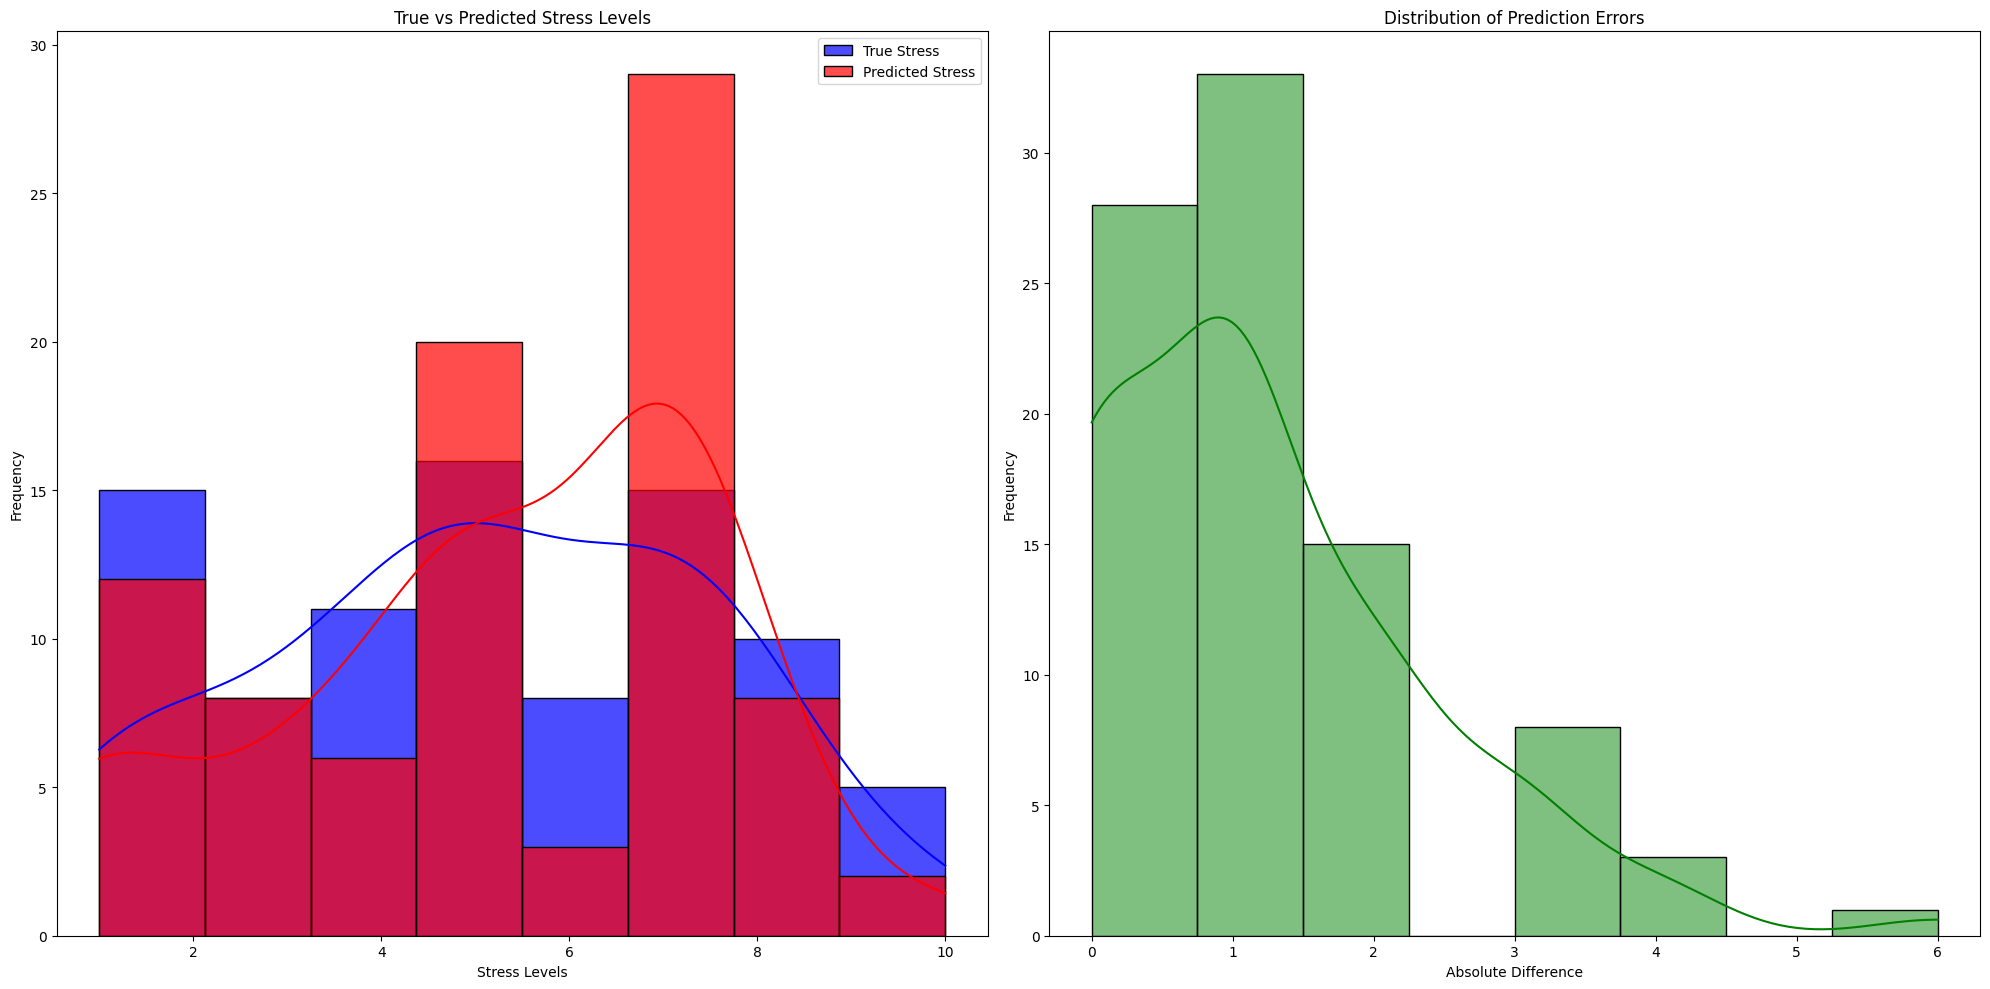

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.histplot(y_test, ax=axes[0], alpha=0.7, label='True Stress', color='blue', kde=True)
sns.histplot(y_pred, ax=axes[0], alpha=0.7, label='Predicted Stress', color='red', kde=True)
axes[0].set_xlabel("Stress Levels")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].set_title("True vs Predicted Stress Levels")

sns.histplot(abs(y_test - y_pred), ax=axes[1], color='green', kde=True)
axes[1].set_xlabel("Absolute Difference")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Prediction Errors")

plt.tight_layout()
plt.show()